# START

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score, log_loss, roc_curve, auc, roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_theme()
%config InlineBackend.figure_format = 'retina'

SEED=25

In [2]:
df = pd.read_pickle('ActiveSiteSeqs SeqVec.pkl')
df.head(2)

,IRED No.,Reaction 2,ee,Enantiomer,enantiomer binary,Sequence,ActiveSiteSequence,CofactorSiteSequence,ActiveSiteCharge,NumOfAcidicRes,NumOfBasicRes,NumOfHisRes,AllActiveSiteRes,embedding,em_per_protein
0,1,"62% (33% ee, S)",33.0,S,1.0,MSTKKVTVIGLGSLGSALAAALLRTGHDVTVWNRTPEKAEALVAQG...,WGMYASSINVALILSAVMAVPADLLLYGYL,WMASSIVAKIGLGSLGSALWNRTPEKVVCVFDTEAARELLNLTSGG...,-1.0,1.0,0.0,0.0,"[('204', 'TRP'), ('207', 'GLY'), ('208', 'MET'...","[[[0.16993958, -0.03258724, 0.05482708, -0.085...","[0.040156763, -0.117751405, -0.030865876, 0.09..."
1,2,"67% (46% ee, S)",46.0,S,1.0,MTDTSAKLTLLGLGAMGSALATAWLAADYDITVWNRTASRAEPLRT...,WAMYTSNMMEGNMTMTGIMAVPPMDVLLSMTF,WTSNMEGTLLGLGAMGSALWNRTASRAACLLDDASVSTLNLTTGGG...,-2.0,2.0,0.0,0.0,"[('209', 'TRP'), ('212', 'ALA'), ('213', 'MET'...","[[[0.16993958, -0.032587238, 0.05482708, -0.08...","[0.05249873, -0.11437141, -0.12927642, -0.0184..."


In [3]:
X = list(df['em_per_protein'])
y = df['enantiomer binary']

In [4]:
# Splitting the data into training and test sets, remember the random_state argument!
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

# Active site sequences

# k-Nearest Neighbours (k-NN)

In [5]:
# Fitting model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Metric evaluation
y_pred = knn.predict(X_test)
knn_logloss = log_loss(y_test, y_pred)

fs_model_list = []
fs_model_score = []
fs_model_list.append('k-NN')
fs_model_score.append(knn_logloss)

# Logistic Regression

In [6]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Metric evaluation
y_pred = logreg.predict(X_test)
logreg_logloss = log_loss(y_test, y_pred)

logreg = logreg_logloss

fs_model_list.append('Logistic regression')
fs_model_score.append(logreg)

# Voting Classifier Ensemble

In [7]:
lr = LogisticRegression(random_state=SEED)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=SEED)
classifiers = [('Logistic Regression', lr),('K Nearest Neighbours', knn),('Classification Tree', dt)]

## Soft voting

In [8]:
vc_soft = VotingClassifier(estimators=classifiers, voting='soft')
vc_soft.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_soft.predict(X_test)
vc_soft_logloss = log_loss(y_test, y_pred)

vc_soft = vc_soft_logloss

fs_model_list.append('Voting classifier soft')
fs_model_score.append(vc_soft)

## Hard voting

In [9]:
vc_hard = VotingClassifier(estimators=classifiers, voting='hard')
vc_hard.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_hard.predict(X_test)
vc_hard_logloss = log_loss(y_test, y_pred)

vc_hard = vc_hard_logloss

fs_model_list.append('Voting classifier hard')
fs_model_score.append(vc_hard)

# Bagging Classifier

In [10]:
dt_bag = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=SEED)
bc = BaggingClassifier(dt_bag, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)

# Metric evaluation
y_pred = bc.predict(X_test)
bc_logloss = log_loss(y_test, y_pred)

bc = bc_logloss

fs_model_list.append('Bagging classifier')
fs_model_score.append(bc)

# XGBoosting

## Data manipulation, fitting, evaluation (accuracy, f1, log loss)

In [11]:
import xgboost as xgb

X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)

xgb_model.fit(X_train_xgb,y_train_xgb)

# Model evaluation
y_pred_xgb = xgb_model.predict(X_test_xgb)
xgb_logloss = log_loss(y_test_xgb, y_pred_xgb)

xgb_model = xgb_logloss

fs_model_list.append('XGBoost')
fs_model_score.append(xgb_model)

[16:15:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Full Sequence

In [12]:
df_2 = pd.read_pickle('Prelim data v2.pkl')
df_2.head(2)

,IRED No.,Reaction 2,ee,Enantiomer,enantiomer binary,Sequence,embedding,em_per_protein
0,1,"62% (33% ee, S)",33.0,S,1.0,MSTKKVTVIGLGSLGSALAAALLRTGHDVTVWNRTPEKAEALVAQG...,"[[[0.013985347, -0.01749879, -0.039746806, -0....","[0.17633651, 0.020518888, 0.033599358, 0.16883..."
1,2,"67% (46% ee, S)",46.0,S,1.0,MTDTSAKLTLLGLGAMGSALATAWLAADYDITVWNRTASRAEPLRT...,"[[[0.013985347, -0.01749879, -0.039746806, -0....","[0.17790619, -0.010589322, 0.038688216, 0.1808..."


In [13]:
X = list(df_2['em_per_protein'])
y = df_2['enantiomer binary']

In [14]:
# Splitting the data into training and test sets, remember the random_state argument!
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

## k-NN

In [15]:
# Fitting model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Metric evaluation
y_pred = knn.predict(X_test)
knn_logloss = log_loss(y_test, y_pred)

fs_model_score.append(knn_logloss)

## Logistic Regression

In [16]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Metric evaluation
y_pred = logreg.predict(X_test)
logreg_logloss = log_loss(y_test, y_pred)

fs_model_score.append(logreg_logloss)

## Voting Classifier - Soft

In [17]:
vc_soft = VotingClassifier(estimators=classifiers, voting='soft')
vc_soft.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_soft.predict(X_test)
vc_soft_logloss = log_loss(y_test, y_pred)

fs_model_score.append(vc_soft_logloss)

## Voting Classifier - Hard

In [18]:
vc_hard = VotingClassifier(estimators=classifiers, voting='hard')
vc_hard.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_hard.predict(X_test)
vc_hard_logloss = log_loss(y_test, y_pred)

fs_model_score.append(vc_hard_logloss)

## Bagging Classifier

In [19]:
dt_bag = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=SEED)
bc = BaggingClassifier(dt_bag, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)

# Metric evaluation
y_pred = bc.predict(X_test)
bc_logloss = log_loss(y_test, y_pred)

fs_model_score.append(bc_logloss)

## XGBoost

In [20]:
import xgboost as xgb

X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)

xgb_model.fit(X_train_xgb,y_train_xgb)

# Model evaluation
y_pred_xgb = xgb_model.predict(X_test_xgb)
xgb_logloss = log_loss(y_test_xgb, y_pred_xgb)

fs_model_score.append(xgb_logloss)

[16:16:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [21]:
big_list = fs_model_list + fs_model_list

fs_data = {'Model': big_list, 'Score': fs_model_score}
results_df = pd.DataFrame(fs_data)

In [28]:
sequence = ['Active site']

In [29]:
sequence = sequence*6

In [30]:
sequence_2 = ['Full sequence']
sequence_2 = sequence_2*6

sequence = sequence + sequence_2

In [31]:
results_df['Sequence'] = sequence
results_df

,Model,Score,Sequence
0,k-NN,5.313719,Active site
1,Logistic regression,3.985336,Active site
2,Voting classifier soft,5.977957,Active site
3,Voting classifier hard,5.313766,Active site
4,Bagging classifier,7.306449,Active site
5,XGBoost,6.642180,Active site
6,k-NN,7.306418,Full sequence
7,Logistic regression,7.306418,Full sequence
8,Voting classifier soft,7.970610,Full sequence
9,Voting classifier hard,7.970610,Full sequence


In [83]:
import seaborn as sns
sns.set(rc={'figure.figsize': (15,15)})
sns.set(font_scale=2.6)
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

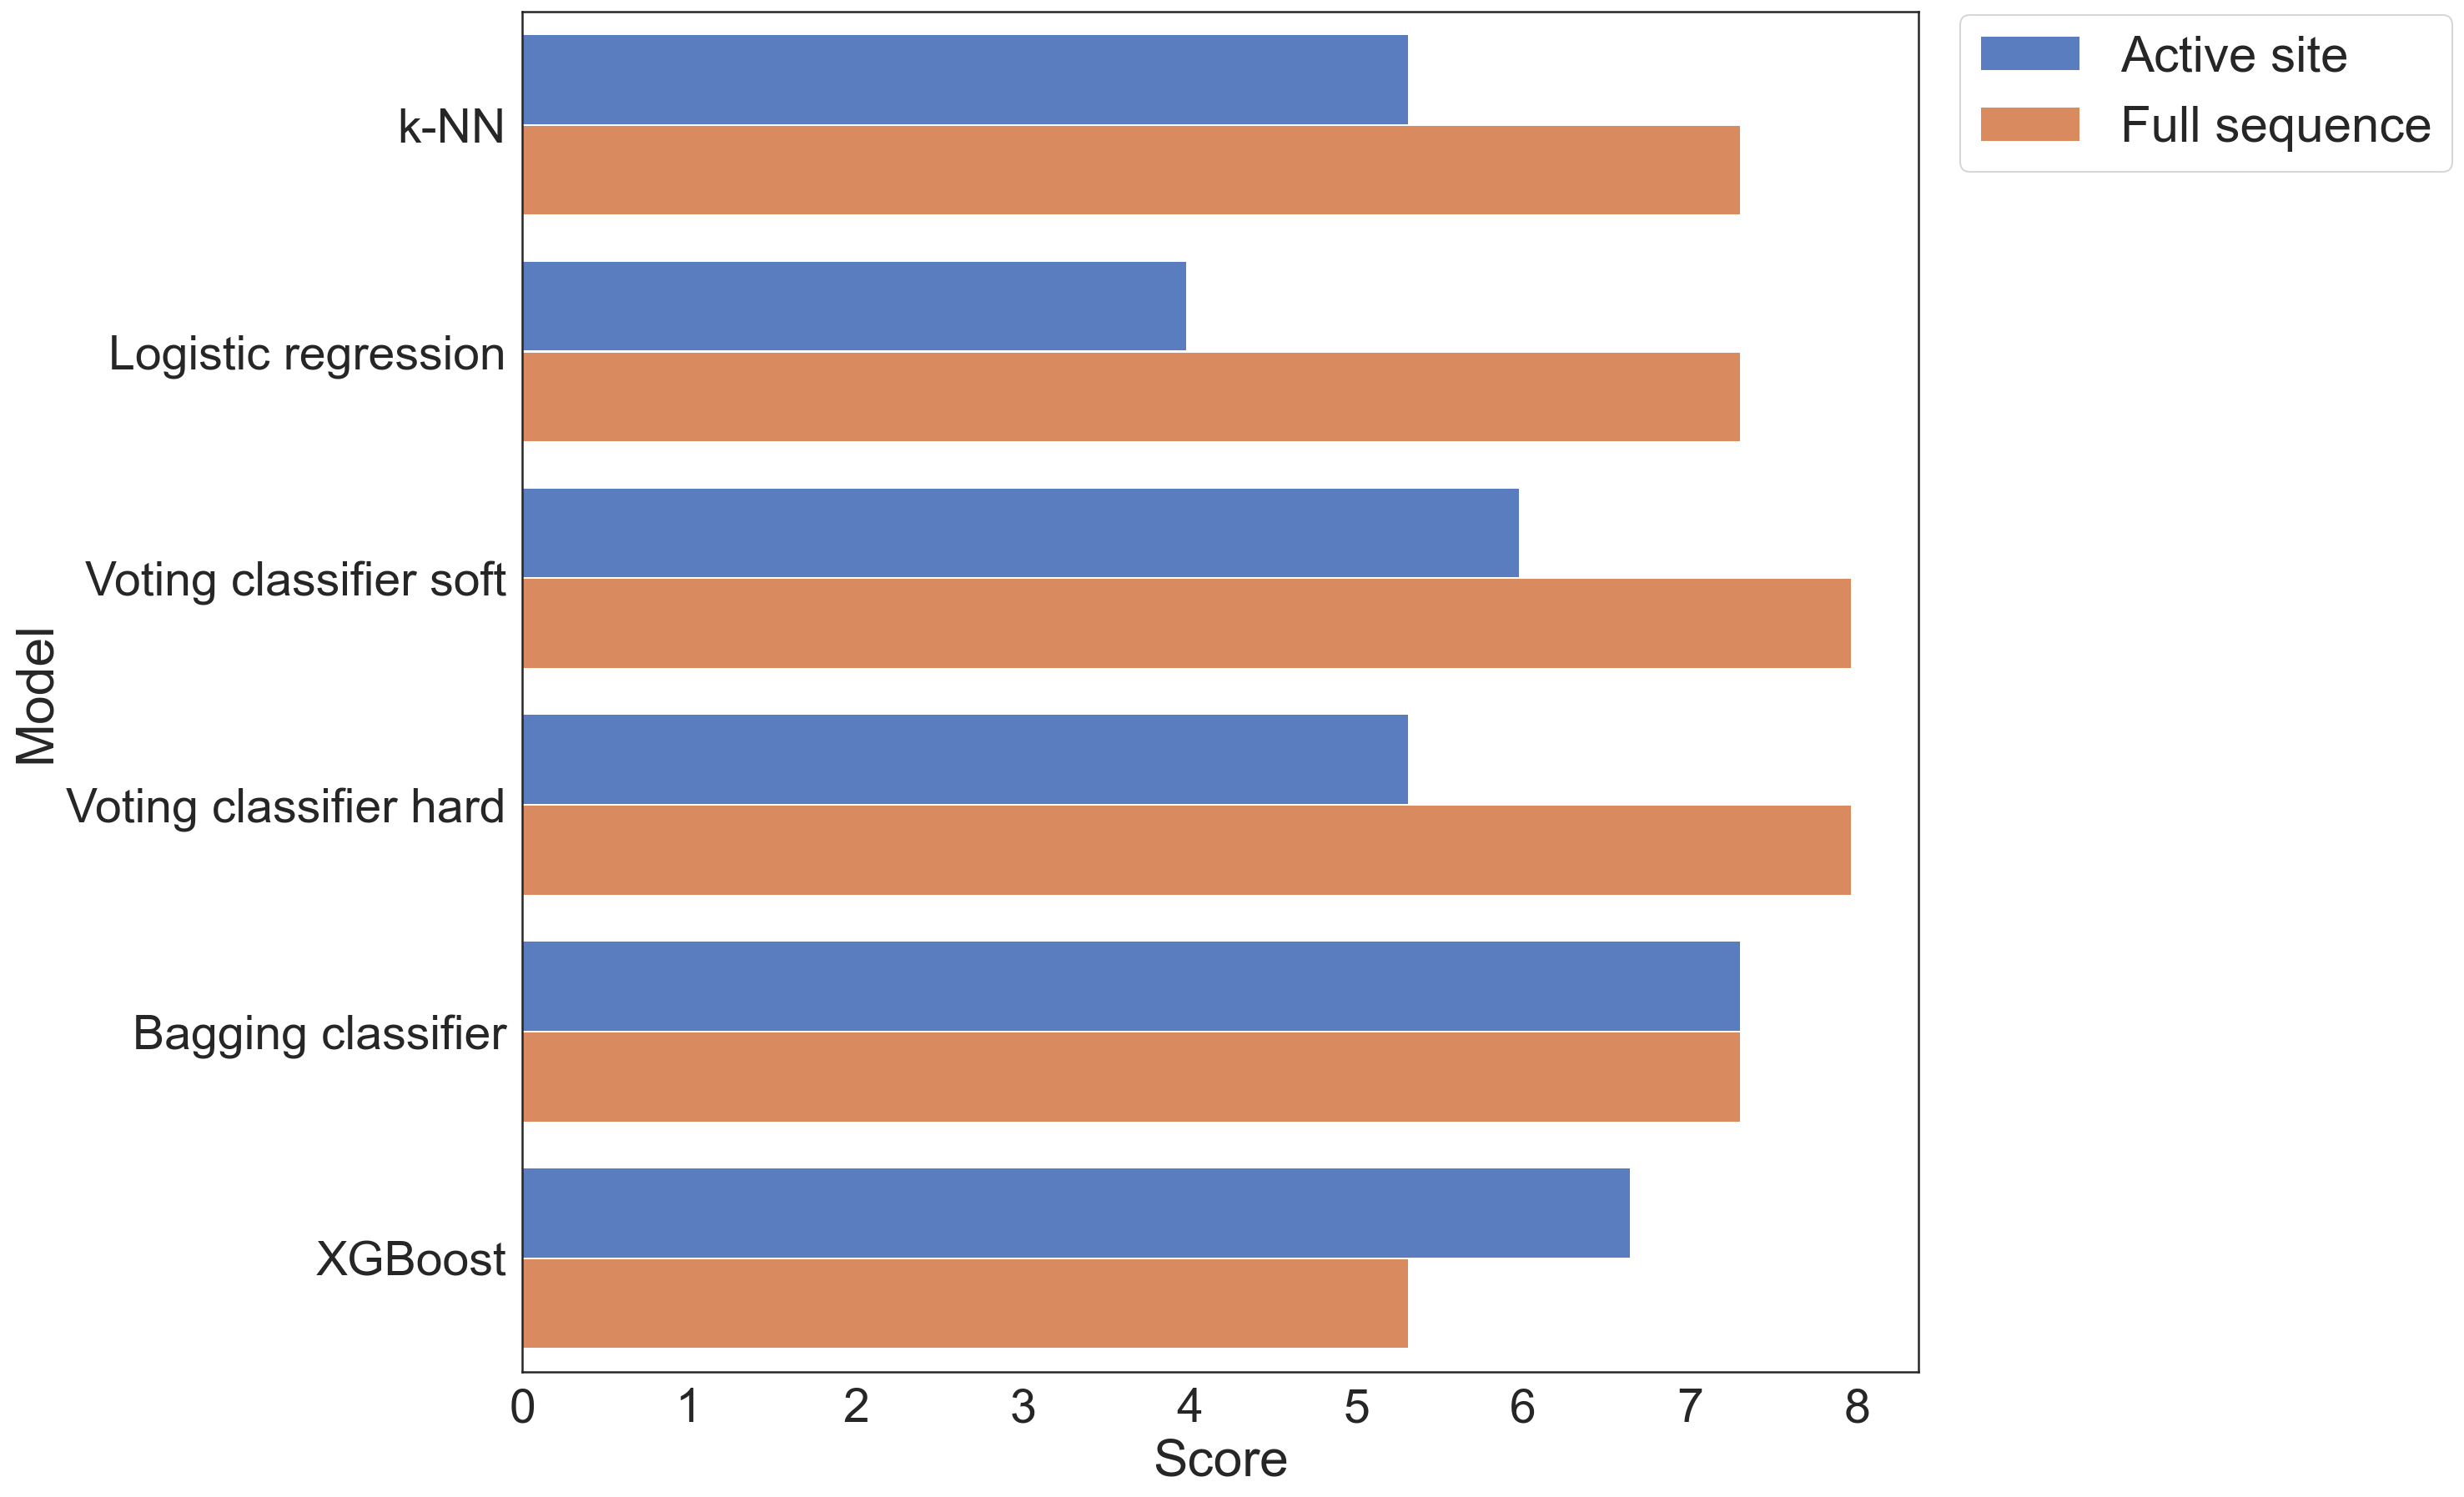

In [87]:
ax = sns.barplot(data=results_df,
                 x='Score',
                 y='Model',
                 hue='Sequence',
                 palette='muted')

ax.legend(fontsize=30,loc='center right', bbox_to_anchor=(1.4, 0.94), ncol=1)

fig = ax.get_figure()
fig.savefig("Log loss scores.png") 